In [31]:
# This notebook illustrates handling the September 2024 Demo of the 18-month epi evaluation scenario 2 question 9

# Import funman related code
import os
from funman import MODE_ODEINT, MODE_SMT, Interval, LinearConstraint
import json
import pandas as pd
import logging
import matplotlib.pyplot as plt
from helpers import run, get_model, setup_common, get_request, report
from funman import to_sympy
from funman.model.generated_models.petrinet import Initial


RESOURCES = "../../resources"
SAVED_RESULTS_DIR = "./out"

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet","monthly-demo", "2024-09")
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "eval_scenario_base_request.json")

models = {
    "sidarthe_observables":  os.path.join(
    EXAMPLE_DIR, "SIDARTHE.model.with.observables.json"),
    "sirhd": os.path.join(
    EXAMPLE_DIR, "sirhd.json"),
    "sirhd-vac": os.path.join(
    EXAMPLE_DIR, "sirhd-vac.json"),
}

requests = {
    "sidarthe_observables": REQUEST_PATH,
    "sirhd-vac": os.path.join(EXAMPLE_DIR, "sirhd-vac-request.json"),
    "sirhd": None,
    "sirhd_stratified": os.path.join(EXAMPLE_DIR, "sirhd-stratified-request.json")
}

states = {
    "sidarthe_observables": ['Susceptible', 'Diagnosed', 'Infected', 'Ailing', 'Recognized', 'Healed', 'Threatened', 'Extinct'],
    "sirhd": ["S", "I", "R", "H", "D"],
    "sirhd-vac": ["S_v", "I_v", "R_v", "H_v", "S_u", "I_u", "R_u", "H_u", "D"],
}


request_params = {}
request_results = {}


# %load_ext autoreload
# %autoreload 2

In [2]:
# Constants for the scenario

MAX_TIME=3
STEP_SIZE=1
timepoints = list(range(0, MAX_TIME+STEP_SIZE, STEP_SIZE))
# model_str = "sidarthe_observables"


1 points
                 N  beta   phd   phr  pih  pir  rhd   rhr   rih   rir
sirhd  150000000.0  0.18  0.13  0.87  0.1  0.9  0.3  0.07  0.07  0.07


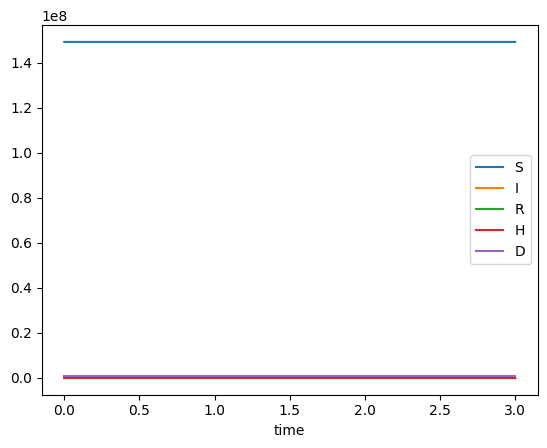

In [3]:
# Base Model
model_str = "sirhd"
(base_model, request) = get_model(models[model_str])
to_plot = base_model._state_var_names() + base_model._observable_names()


funman_request = get_request(models[model_str])
setup_common(funman_request, timepoints, debug=True, mode=MODE_SMT, synthesize=False,dreal_precision=0.1)
results = run(funman_request, model_str, models)
report(results, model_str, to_plot, request_results, request_params)

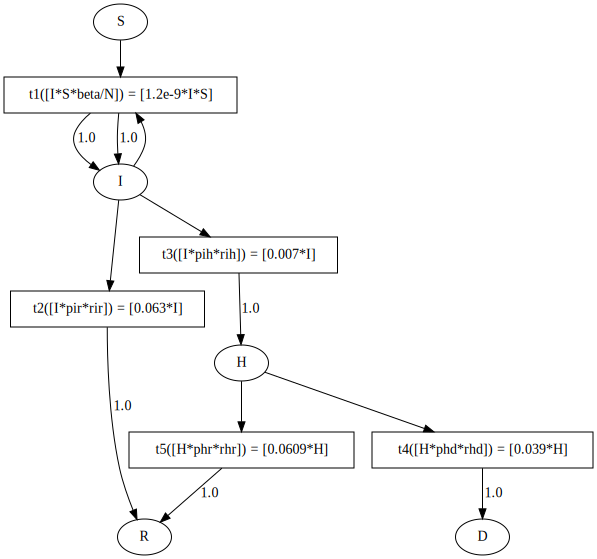

In [7]:
base_model.to_dot()

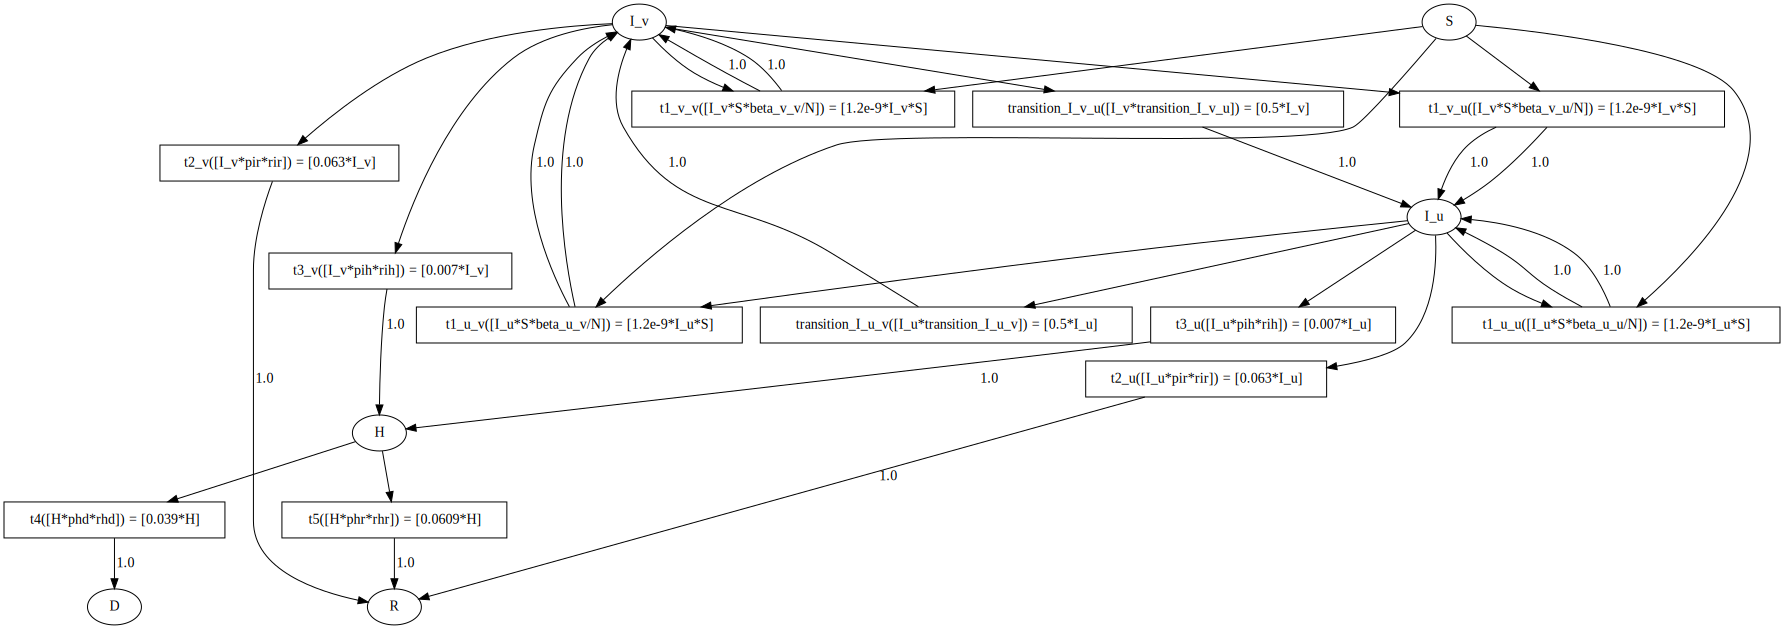

In [33]:

# Stratify model with vaccination status

from typing import Dict, List, Optional
from funman.model.generated_models.petrinet import Model1, Parameter, Rate, State,Transition, Properties, Model, Semantics, OdeSemantics, Initial
from funman.model.petrinet import GeneratedPetriNetModel, PetrinetModel
from sympy import Symbol




def stratify(self: PetrinetModel, state_var: str, strata: List[str], strata_parameter:Optional[str]=None, strata_transitions=[], self_strata_transition=False):
    
    # get state variable
    state_vars: List[State] = [s for s in self._state_vars() if self._state_var_name(s) == state_var]
    assert len(state_vars) == 1, "Found more than one State variable for {state_var}"
    original_var = state_vars[0]
    new_vars = [State(id=f"{original_var.id}_{level}", name=f"{original_var.name}_{level}", description=f"{original_var.description} Stratified wrt. {level}", grounding=original_var.grounding, units=original_var.units) for level in strata]
    unchanged_vars = [ s.id for s in self._state_vars() if s != original_var]
    
    # get new transitions
    transitions: Dict[str, Transition] = {t.id: t for t in self._transitions() if original_var.id in t.input or original_var.id in t.output}
    other_transitions = {t.id: t for t in self._transitions() if t.id not in transitions}
    
    src_only_transitions: Dict[str, Transition]  = {t_id: t for t_id, t in transitions.items() if original_var.id in t.input and original_var.id not in t.output}
    dest_only_transitions: Dict[str, Transition]  = {t_id: t for t_id, t in transitions.items() if original_var.id not in t.input and original_var.id in t.output}
    src_and_dest_transitions: Dict[str, Transition] = {t_id: t for t_id, t in transitions.items() if original_var.id in t.input and original_var.id in t.output }
    
    # Replicate transitions where original_var is in source
    new_src_transitions = [
        Transition(id=f"{t.id}_{level}", 
                   input=[(s if s!= original_var.id else f"{s}_{level}") for s in t.input], 
                   output=t.output, 
                   grounding=t.grounding, 
                   properties=Properties(name=f"{t.properties.name}_{level}", description=(f"{t.properties.description} Stratified wrt. {level}" if t.properties.description else t.properties.description))) 
        for t_id, t in src_only_transitions.items()
        for level in strata
        ]
    
    # Replicate transitions where original_var is in destination
    new_dest_transitions = [
        Transition(id=f"{t.id}_{level}", 
                   input=t.input, 
                   output=[(s if s!= original_var.id else f"{s}_{level}") for s in t.output], 
                   grounding=t.grounding, 
                   properties=Properties(name=f"{t.properties.name}_{level}", description=(f"{t.properties.description} Stratified wrt. {level}" if t.properties.description else t.properties.description))) 
        for t_id,t in dest_only_transitions.items()
        for level in strata
        ]
    
    # Replicate transitions where original_var is in source and destination
    new_src_dest_transitions = [
        Transition(id=f"{t.id}_{level_s}_{level_t}", 
                   input=[(s if s!= original_var.id else f"{s}_{level_s}") for s in t.input], 
                   output=[(s if s!= original_var.id else f"{s}_{level_t}") for s in t.output], 
                   grounding=t.grounding, 
                   properties=Properties(name=f"{t.properties.name}_{level_s}_{level_t}", description=(f"{t.properties.description} Stratified wrt. {level_s}, {level_t}." if t.properties.description else t.properties.description))) 
        for t_id,t in src_and_dest_transitions.items()
        for level_s in strata
        for level_t in strata
        if t_id in strata_transitions or level_s == level_t
        ]
    
    new_transitions = new_src_transitions +new_dest_transitions + new_src_dest_transitions
        
    # Modify rates by substituting fresh versions of the strata_parameter
    old_rates = {t_id: self._transition_rate(t) for t_id, t in transitions.items()}
    other_rates = {r.target: r for r in self.petrinet.semantics.ode.rates if r.target in other_transitions}
    
    src_only_rates = [
        Rate(
            target=f"{t_id}_{level}", 
            expression=(str(r[0]).replace(strata_parameter, f"{strata_parameter}_{level}").replace(state_var, f"{state_var}_{level}") if strata_parameter else r[0].replace(state_var, f"{state_var}_{level}"))) 
        for t_id,r in old_rates.items() 
        if t_id in src_only_transitions 
        for level in strata]

    dest_only_rates = [
        Rate(
            target=f"{t_id}_{level}", 
            expression=(str(r[0]).replace(strata_parameter, f"{strata_parameter}_{level}").replace(state_var, f"{state_var}_{level}") if strata_parameter else r[0].replace(state_var, f"{state_var}_{level}"))) 
        for t_id,r in old_rates.items() 
        if t_id in dest_only_transitions 
        for level in strata]

    src_and_dest_rates = [
            Rate(
                target=f"{t_id}_{level_s}_{level_t}", 
                expression=(str(r[0]).replace(strata_parameter, f"{strata_parameter}_{level_s}_{level_t}").replace(state_var, f"{state_var}_{level_s}") if strata_parameter else r[0].replace(state_var, f"{state_var}_{level_s}"))) 
            for t_id,r in old_rates.items() 
            if t_id in src_and_dest_transitions 
            for level_s in strata for level_t in strata
        ]

    new_rates = src_only_rates + dest_only_rates + src_and_dest_rates

    new_states = new_vars + [s for s in self.petrinet.model.states.root if s not in state_vars]
    
    # update with new states by splitting old state values
    original_init_value = to_sympy(next(i.expression for i in self.petrinet.semantics.ode.initials if i.target == original_var.id), {})
    
    new_initials = [i for i in self.petrinet.semantics.ode.initials if i.target in unchanged_vars] + [
        Initial(target=n.id, expression=str(original_init_value/float(len(new_vars))))
        for n in new_vars
    ]
    
    # FIXME update with split parameters
    if strata_parameter is not None:
        original_parameter_value = self._parameter_values()[strata_parameter]
        original_parameter = next(iter([p for p in self.petrinet.semantics.ode.parameters if p.id == strata_parameter]))
        unchanged_parameters = [p for p in self.petrinet.semantics.ode.parameters if p.id != strata_parameter]
        src_only_parameters = list(set([
            f"{strata_parameter}_{level}" 
            for t_id,r in old_rates.items() 
            if t_id in src_only_transitions and Symbol(strata_parameter) in old_rates[t_id][0].free_symbols 
            for level in strata
        ]))

        dest_only_parameters = list(set([
            f"{strata_parameter}_{level}" 
            for t_id,r in old_rates.items() 
            if t_id in dest_only_transitions and Symbol(strata_parameter) in old_rates[t_id][0].free_symbols 
            for level in strata
            ]))

        src_and_dest_parameters = [
            Parameter(id=f"{strata_parameter}_{level_s}_{level_t}", name = f"{strata_parameter}_{level_s}_{level_t}", description=f"{original_parameter.description} stratified as {strata_parameter}_{level_s}_{level_t}", value=original_parameter_value, distribution=original_parameter.distribution, units=original_parameter.units, grounding=original_parameter.grounding)
            for t_id,r in old_rates.items() 
            if t_id in src_and_dest_transitions and Symbol(strata_parameter) in old_rates[t_id][0].free_symbols 
            for level_s in strata for level_t in strata
        ]
        new_parameters = unchanged_parameters + src_only_parameters + dest_only_parameters + src_and_dest_parameters
    else:
        new_parameters = self.petrinet.semantics.ode.parameters
    
    # FIXME update with splits
    new_observables = self.petrinet.semantics.ode.observables
    
    self_strata_transitions = [Transition(id=f"transition_{state_var}_{level_s}_{level_t}", input=[f"{state_var}_{level_s}"], output=[f"{state_var}_{level_t}"], grounding=None, properties={"name": f"transition_{state_var}_{level_s}_{level_t}"}) for level_s in strata for level_t in strata if level_s != level_t]
    self_strata_rates = [Rate(target=f"transition_{state_var}_{level_s}_{level_t}", expression=f"{state_var}_{level_s}*transition_{state_var}_{level_s}_{level_t}") for level_s in strata for level_t in strata if level_s != level_t]
    self_strata_parameters = [Parameter(id=f"transition_{state_var}_{level_s}_{level_t}", name=f"transition_{state_var}_{level_s}_{level_t}", description="Transition rate parameter between {state_var} strata {level_s} and {level_t}.", value=1.0/float(len(strata))) for level_s in strata for level_t in strata if level_s != level_t]
    
    
    
    new_model = GeneratedPetriNetModel(
                    petrinet=Model(
                        header=self.petrinet.header,
                        properties=self.petrinet.properties,
                        model=Model1(
                          states=new_states, 
                          transitions=[*new_transitions, *other_transitions.values(), *self_strata_transitions]
                          ),
                        semantics=Semantics(
                          ode=OdeSemantics(
                              rates=[*new_rates, *other_rates.values(), *self_strata_rates], 
                              initials=new_initials, 
                              parameters=new_parameters+self_strata_parameters, 
                              observables=new_observables,
                              time=self.petrinet.semantics.ode.time), 
                          typing=self.petrinet.semantics.typing, span=self.petrinet.semantics.span),
                      metadata=self.petrinet.metadata
                      ))

    return new_model #new_rates, transitions, new_transitions # dest_only_rates #original_var, new_vars, new_transitions
    
stratified_model = stratify(base_model, "I", ["u", "v"], strata_parameter="beta", strata_transitions=["t1"], self_strata_transition=True)
stratified_model_str = f"{model_str}_stratified"

stratified_model_path = os.path.join(EXAMPLE_DIR, stratified_model_str+".json")
models[stratified_model_str] = stratified_model_path
with open(stratified_model_path, "w") as f:
    f.write(stratified_model.petrinet.model_dump_json())


stratified_model.to_dot()


1 points
                            N  beta_u_u  beta_u_v  beta_v_u  beta_v_v   phd  \
sirhd_stratified  150000000.0      0.18      0.18      0.18      0.18  0.13   

                   phr  pih  pir  rhd   rhr   rih   rir  transition_I_u_v  \
sirhd_stratified  0.87  0.1  0.9  0.3  0.07  0.07  0.07               0.5   

                  transition_I_v_u  
sirhd_stratified               0.5  


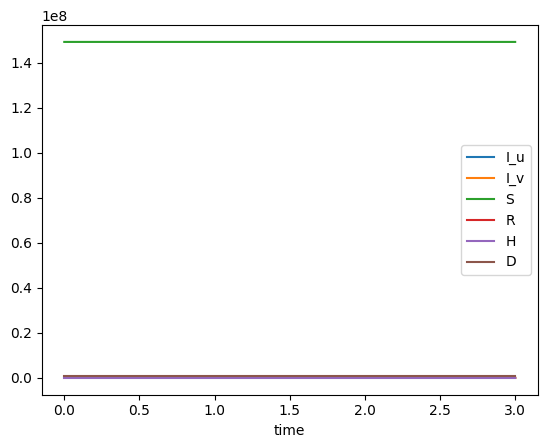

In [36]:
# Analyze Stratified Base Model

from funman.server.query import FunmanWorkRequest


to_plot = stratified_model._state_var_names() + stratified_model._observable_names()



stratified_request = get_request(models[model_str])
# stratified_request = FunmanWorkRequest()
setup_common(stratified_request, timepoints, debug=True, mode=MODE_SMT, synthesize=False,dreal_precision=0.1)
results = run(stratified_request, stratified_model_str, models)
report(results, stratified_model_str, to_plot, request_results, request_params)

In [40]:
results.points()[0].simulation
# stratified_request

Timeseries(data=[[0.0, 1.0, 2.0, 3.0], [500.0, 666.9692227999795, 889.6653629654517, 1186.752633952176], [500.0, 666.9692227999795, 889.6653629654517, 1186.752633952176], [149217546.0, 149217130.93021733, 149216577.328128, 149215838.7957602], [0.0, 73.24600202799245, 171.3870330036324, 302.7185795636775], [0.0, 7.739454251973908, 17.326525975274247, 29.45016764609824], [781454.0, 781454.1458808719, 781454.6275871565, 781455.5302247496]], columns=['time', 'I_u', 'I_v', 'S', 'R', 'H', 'D'])

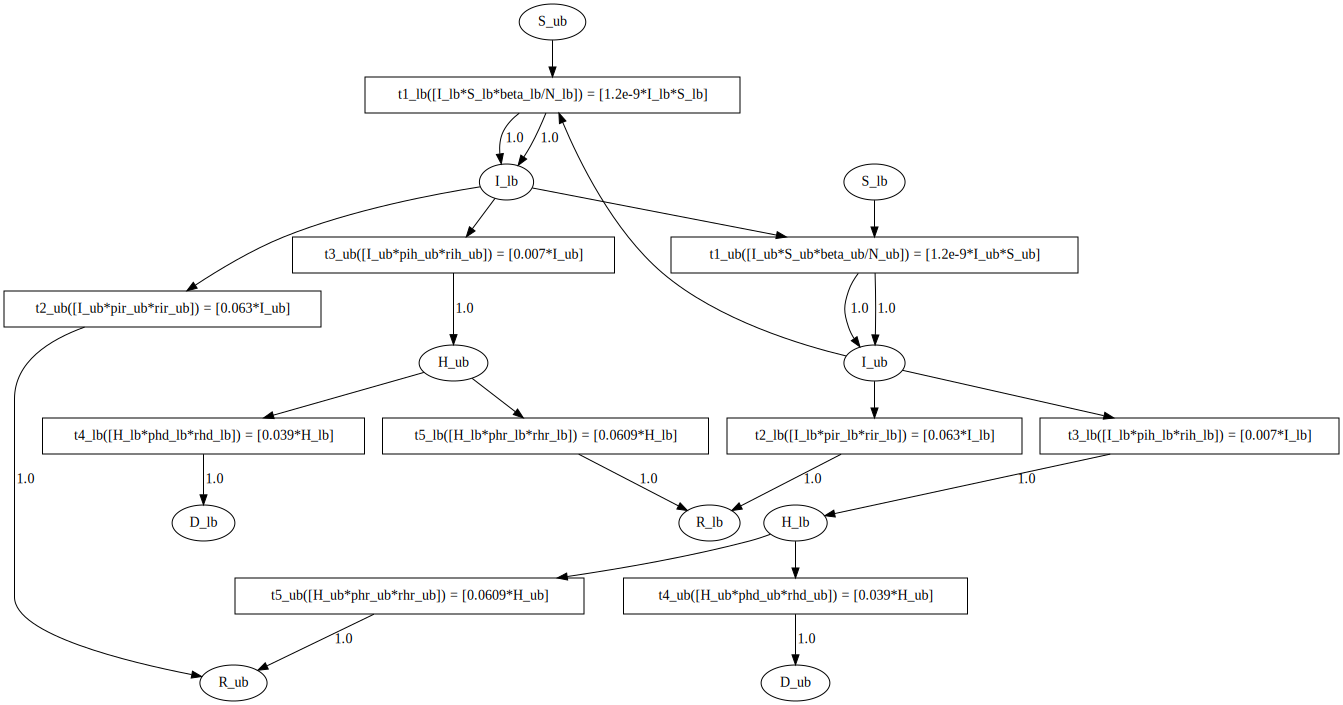

In [ ]:
# from sympy import sympify, Symbol

def formulate_bounds(self: GeneratedPetriNetModel):
    # Reformulate model into bounded version 
    # - replace each state S by S_lb adn S_ub
    # - replace each transition T by T_lb and T_ub
    # - replace related parameters by their lb and ub
    # - replace rates by transition type
    
    # lb subtracts ub rate
    # lb adds lb rate
    
    # ub subtracts lb rate
    # ub adds ub rate
    
    bounded_states = [
            State(id=f"{s.id}_lb", name=f"{s.id}_lb", 
                  description=f"{s.description} lb", 
                  grounding=s.grounding, units=s.units) 
            for s in self.petrinet.model.states
        ] + [
            State(id=f"{s.id}_ub", name=f"{s.id}_ub", 
                  description=f"{s.description} ub", 
                  grounding=s.grounding, units=s.units) 
            for s in self.petrinet.model.states
        ]
    bounded_transitions = [
        Transition(id=f"{t.id}_lb", 
                   input=[f"{s}_ub" for s in t.input], 
                   output=[f"{s}_lb"  for s in t.output], 
                   grounding=t.grounding, 
                   properties=Properties(
                       name=f"{t.id}_lb", 
                       description=(f"{t.properties.description} lb" if t.properties.description else t.properties.description))) 
        for t in self.petrinet.model.transitions
    ] + [
        Transition(id=f"{t.id}_ub", 
                   input=[f"{s}_lb" for s in t.input], 
                   output=[f"{s}_ub"  for s in t.output], 
                   grounding=t.grounding, 
                   properties=Properties(
                       name=f"{t.id}_ub", 
                       description=(f"{t.properties.description} ub" if t.properties.description else t.properties.description)))
        for t in self.petrinet.model.transitions
    ]
    
    
    def bound_expression(e, symbols, bound):
        f = to_sympy(e, symbols)
        f_b = f.subs({s: f"{s}_{bound}" for s in symbols})
        return f_b
    
    def lb_expression(e, symbols):
        return bound_expression(e, symbols, "lb")
    
    def ub_expression(e, symbols):
       return bound_expression(e, symbols, "ub")
    
    symbols = self._symbols()
    
    # lb transitions use rates that will:
    #   - decrease ub terms by the least amount
    #   - increase lb terms by the least amount
    # ub transitions use rates that will:
    #   - vice versa wrt. above
    
    bounded_rates = [
        Rate(target=f"{r.target}_lb", 
             expression=str(lb_expression(r.expression, symbols))) 
        for r in self.petrinet.semantics.ode.rates
    ] + [
        Rate(target=f"{r.target}_ub", 
             expression=str(ub_expression(r.expression, symbols))) 
        for r in self.petrinet.semantics.ode.rates
    ]
    bounded_initials = [
        Initial(target=f"{r.target}_lb", 
             expression=r.expression,
             expression_mathml=r.expression_mathml) 
        for r in self.petrinet.semantics.ode.initials
    ] + [
        Initial(target=f"{r.target}_ub", 
             expression=r.expression,
             expression_mathml=r.expression_mathml)
        for r in self.petrinet.semantics.ode.initials
    ]
    
    bounded_parameters = [
        Parameter(id=f"{r.id}_lb", 
             value=r.value,
             units=r.units) 
        for r in self.petrinet.semantics.ode.parameters
    ] + [
        Parameter(id=f"{r.id}_ub", 
             value=r.value,
             units=r.units)
        for r in self.petrinet.semantics.ode.parameters
    ]
    
    bounded_observables = []
    
     
    return GeneratedPetriNetModel(petrinet=Model(
                header=self.petrinet.header,
                properties=self.petrinet.properties,
                model=Model1(
                          states=bounded_states, 
                          transitions=bounded_transitions
                          ),
                semantics=Semantics(
                          ode=OdeSemantics(
                              rates=bounded_rates, 
                              initials=bounded_initials, 
                              parameters=bounded_parameters, 
                              observables=bounded_observables,
                              time=self.petrinet.semantics.ode.time), 
                          typing=self.petrinet.semantics.typing, 
                          span=self.petrinet.semantics.span
                          ),
                metadata=self.petrinet.metadata
            ))
    
mb = formulate_bounds(base_model)
mb.to_dot()

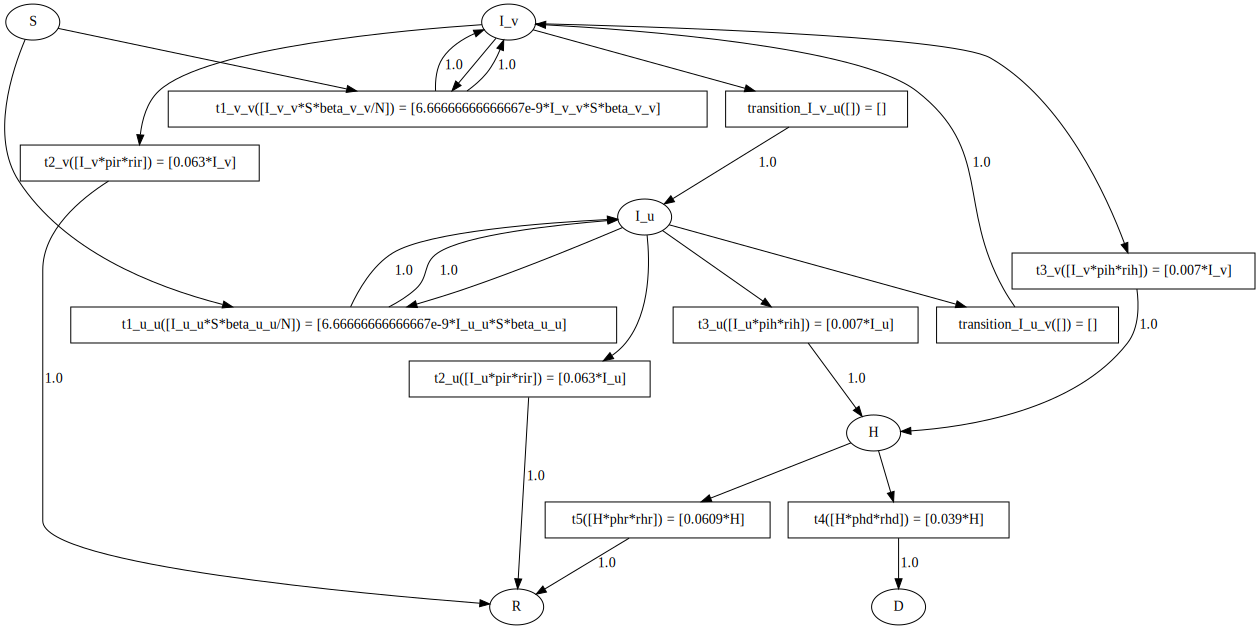

In [ ]:
stratify(base_model, "I", ["u", "v"], strata_parameter="beta", strata_transitions=["t3"], self_strata_transition=True).to_dot()


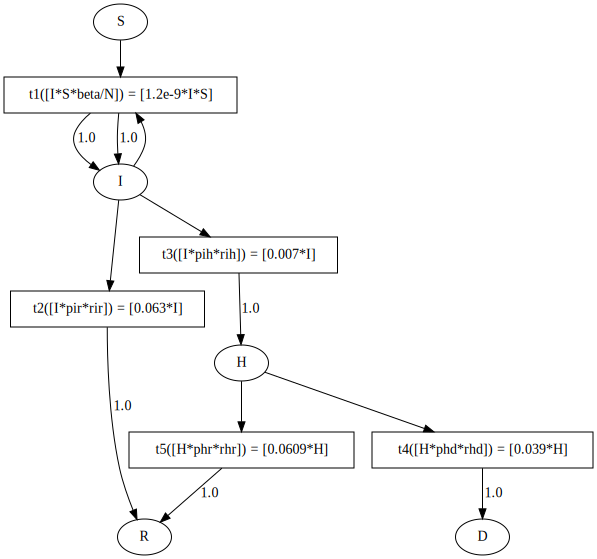

In [ ]:
base_model.to_dot()